In [1]:
%pylab inline

from scipy.stats.distributions import skewnorm
from scipy.optimize import leastsq
from scipy.ndimage import gaussian_filter
from densitycontour import densitycontour

Populating the interactive namespace from numpy and matplotlib


In [2]:
rc("font", size=20)
rc("text", usetex=True, **{"latex.preamble":r"\usepackage{amsmath},\usepackage{txfonts},\usepackage{eulervm},\usepackage{helvet}", "hinting":"native"})
rc("figure", figsize=(5,5))
rc("axes", linewidth=0.3)
rc("xtick.major", width=0.3)
rc("ytick.major", width=0.3)
rc("xtick.minor", width=0.3)
rc("ytick.minor", width=0.3)
rc("xtick", labelsize="x-small")
rc("ytick", labelsize="x-small")
rc("hatch", linewidth=0.5)
rc("grid", linewidth=0.3)
rc("savefig", format="pdf", dpi=50, bbox="tight")

In [3]:
random.seed(0)

# modelo real
real_model = lambda x, params: x**params[0]+params[1]
# modelo propuesto
model = lambda x, params: params[0]*x+params[1]
# definir verosimilitud del modelo asumido para reproducir cada observación
def lik_i(x, y, sigma, params):
    return 1.0/sqrt(2*pi*sigma**2)*exp(-((model(x, params)-y)/(2*sigma))**2)
# definir verosimilitud verdadera del modelo asumido para reproducir cada observación
def real_lik_i(x, y, sigma, params):
    return 1.0/sqrt(2*pi*sigma**2)*exp(-((real_model(x, params)-y)/(2*sigma))**2)
# definir prior objetivo
def naive_prior(m, b):
    return 1.0/(range_m[-1]-range_m[0])*1.0/(range_b[-1]-range_b[0])
# definir prior informativo
def inf_prior(m, b, mu_m=1.0, sigma_m=0.5, mu_b=-1.0, sigma_b=1.0):
    return normpdf(m, mu_m, sigma_m) * normpdf(b, mu_b, sigma_b)
# definir calculo del nivel ~ percentile
def percentile_to_level(X, Y, PDF, percentile, tol=0.001, max_iter=1000):
    PDF_ = copy(PDF)
    PDF_[isnan(PDF)] = PDF_[~isnan(PDF)].min()
    x = unique(X)
    y = unique(Y)
    Z_min = PDF_.min()
    if Z_min<0.0: PDF_ -= Z_min
    Z_max = PDF_.max()
    PDF_ /= Z_max
    volume = (array([diff(x)]).repeat(y.size,axis=0).T*(PDF_[:-1,:]+PDF_[1:,:])*0.5).sum(axis=0)
    volume = (diff(y)*(volume[:-1]+volume[1:])*0.5).sum()
    step = -0.1
    delta = 999.9
    levels = [1.0]
    pers = [0.0]
    while True:
        mask = PDF_>=levels[-1]+step
        Z = copy(PDF_)
        Z[~mask] = 0.0
        pseudo_vol = (array([diff(x)]).repeat(y.size,axis=0).T*(Z[:-1,:]+Z[1:,:])*0.5).sum(axis=0)
        pseudo_vol = (diff(y)*(pseudo_vol[:-1]+pseudo_vol[1:])*0.5).sum()
        levels.append(levels[-1]+step)
        pers.append(pseudo_vol/volume)
        delta = percentile-pers[-1]
        if tol>abs(delta) or len(levels)>=max_iter: break
        if (delta>0 and step>0) or (delta<0 and step<0): step *= -1.0
        if levels[-1]+step in levels: step *= 0.5
    levels[-1] *= Z_max
    if Z_min<0.0: levels[-1] += Z_min
    return levels[-1]
# definir clipping
def last(nbin, span):
    return span[0], span[-1]+diff(span)/nbin
# definir log enmascarado
def masked_log(matrix):
    matrix_ = copy(matrix)
    matrix_[matrix_==0.0] = 1.0
    matrix_ = log(matrix_)
    matrix_[matrix_==0.0] = np.nan
    return matrix_

# parametros
range_m, range_b = (-20,+20), (-100,+100)
real_params = (1.5, 0.0)
# simulación de la observación
N_obs = 20
N_uni = 100
X = linspace(0,10,N_uni)
x = sort(X[0]+random.rand(N_obs)*(X[-1]-X[0]))
sk, mu, sigma = 3, -0.55, 1.2
sk, mu, sigma = 0, 0, 4.0
obs = real_model(x, real_params) + skewnorm.rvs(sk, mu, sigma, size=N_obs)

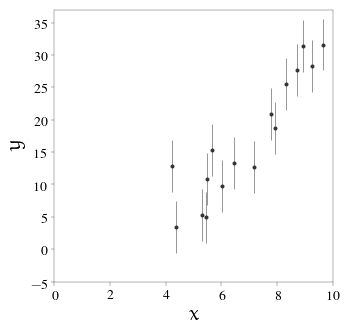

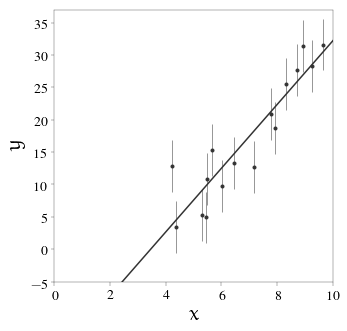

In [4]:
mask_linear = x>4.0

# gráfico del conjunto de datos
figure()
errorbar(x[mask_linear], obs[mask_linear], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
xlim(0, 10)
ylim(-5, 37)
xlabel(r"$x$")
ylabel(r"$y$")

# definir función a minimizar
residuals = lambda params: obs[mask_linear] - model(x[mask_linear], params)
initial_params = [0.5, 0.0]
lsq_params = leastsq(residuals, initial_params, full_output=True)
lin_params = lsq_params[0]
lin_cov = lsq_params[1]
# gráfico del ajuste por mínimos cuadrados
figure()
plot(X, model(X, lin_params), "-", color="0.2", lw=1.5)
errorbar(x[mask_linear], obs[mask_linear], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
xlim(0, 10)
ylim(-5, 37)
xlabel(r"$x$")
ylabel(r"$y$")

In [5]:
# definir percentiles de interés
percentiles = [0.95,0.68,0.025]
# definir forma del espacio [x,m,b]
shape = N_uni, N_uni, N_uni
# simular universo de observaciones sin ruido
XX_uni, MM_uni, BB_uni = meshgrid(linspace(X[0],X[-1],shape[0]), linspace(range_m[0],range_m[-1],shape[1]), linspace(range_b[0],range_b[-1],shape[2]), indexing="ij")
YY_uni = real_model(XX_uni, real_params)
# calcular la verosimilitud del modelo a la luz del universo de observaciones
uni_lik = masked_log(lik_i(XX_uni, YY_uni, sigma, [MM_uni,BB_uni]).prod(axis=0))
# calcular la verosimilitud del modelo a la luz de observaciones limitadas
XX_obs, MM_obs, BB_obs = meshgrid(x[mask_linear], linspace(range_m[0],range_m[-1],shape[1]), linspace(range_b[0],range_b[-1],shape[2]), indexing="ij")
YY_obs, MM_obs, BB_obs = meshgrid(obs[mask_linear], linspace(range_m[0],range_m[-1],shape[1]), linspace(range_b[0],range_b[-1],shape[2]), indexing="ij")
obs_lik = masked_log(lik_i(XX_obs, YY_obs, sigma, [MM_obs,BB_obs]).prod(axis=0))

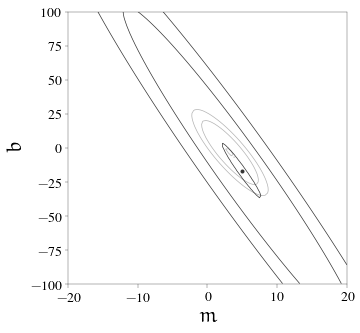

In [12]:
# graficar solución MLE
figure()
contour(MM_uni[0], BB_uni[0], uni_lik, [percentile_to_level(MM_uni[0],BB_uni[0],uni_lik,per) for per in percentiles], linewidths=0.7, colors="0.7", linestyles="-")
contour(MM_obs[0], BB_obs[0], obs_lik, [percentile_to_level(MM_obs[0],BB_obs[0],obs_lik,per) for per in percentiles], linewidths=0.7, colors="0.2", linestyles="-")
plot(lin_params[0], lin_params[1], ".", color="0.2")
xlim(*range_m)
ylim(*range_b)
xlabel(r"$m$")
ylabel(r"$b$")

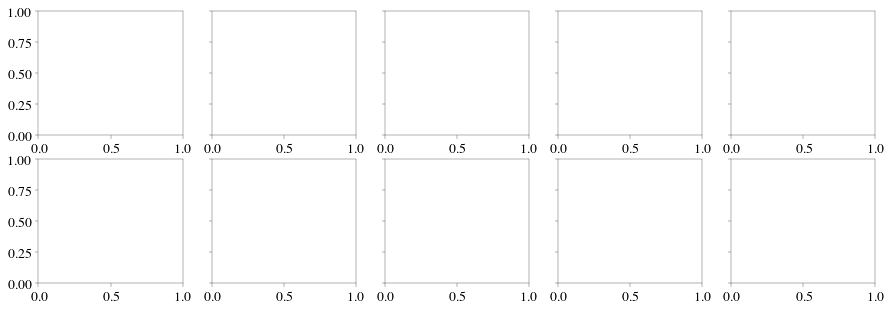

In [11]:
fig, axs = subplots(2,5, figsize=(15,5), sharex="row", sharey=True)



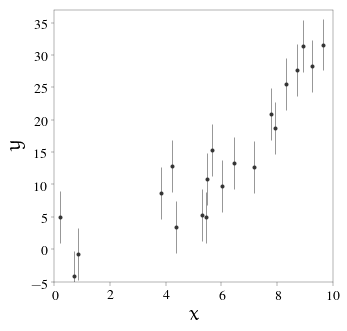

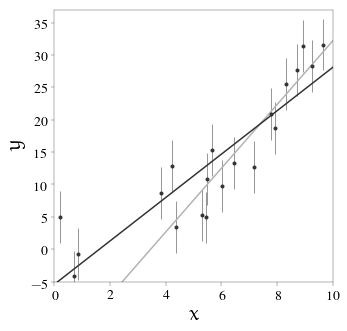

In [7]:
mask_nlinear = x>0.0

# gráfico del conjunto de datos
figure()
errorbar(x[mask_nlinear], obs[mask_nlinear], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
xlim(0, 10)
ylim(-5, 37)
xlabel(r"$x$")
ylabel(r"$y$")

# gráfico del ajuste por mínimos cuadrados
figure()
# definir función a minimizar
residuals = lambda params: obs[mask_nlinear] - model(x[mask_nlinear], params)
initial_params = [0.5, 0.0]
lsq_params = leastsq(residuals, initial_params, full_output=True)
nli_params = lsq_params[0]
nli_cov = lsq_params[1]

plot(X, model(X, lin_params), "-", color="0.7", lw=1.5)
plot(X, model(X, nli_params), "-", color="0.2", lw=1.5)
errorbar(x[mask_nlinear], obs[mask_nlinear], sigma, fmt=".", ecolor="0.2", color="0.2", lw=0.5)
xlim(0, 10)
ylim(-5, 37)
xlabel(r"$x$")
ylabel(r"$y$")